## Causal Forest 

Replication of Athey & Wager 2018.
By Alvaro, Luis, Diego

### Data

In [37]:
# install.packages("Hmisc")
#install.packages("grf")

In [38]:
set.seed(1)

rm(list = ls())

library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

data.all = read.csv("https://raw.githubusercontent.com/grf-labs/grf/master/experiments/acic18/synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)


In [39]:
head(DF)

,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.08160167,6,4,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
2,1,-0.38586896,4,12,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
3,1,0.39818373,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
4,1,-0.17503685,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
5,1,0.88458337,6,4,1,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,1,-0.09056477,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567


### 1. How the tree was built?

In [40]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.

w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)

W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)



Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [41]:
# Grow a forest. Add extra trees for the causal forest.
#

Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions


### 2. Estimate ATE

In [42]:
ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))


[1] "95% CI for the ATE: 0.248 +/- 0.04"

This result means that the average treatment effect is 0.248, significant and positive.

### 3. Run best linear predictor analysis

In [43]:

test_calibration(cf)

# Compare regions with high and low estimated CATEs
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.992560   0.082569 12.0210 <2e-16 ***
differential.forest.prediction 0.275835   0.616262  0.4476 0.3272    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "95% CI for difference in ATE: 0.037 +/- 0.073"

In this part we observe that "mean.forest.prediction" has a coefficient very close to one and significant, this indicates that the causal forest was able to find heterogeneity.

In [44]:
# formal test for X1 and X2
#

dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])

school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])

school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0796, df = 71.402, p-value = 0.002942
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19481996 -0.04169622
sample estimates:
mean of x mean of y 
0.1885602 0.3068183 



	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 1.0011, df = 72.229, p-value = 0.3201
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04020131  0.12131665
sample estimates:
mean of x mean of y 
0.2679681 0.2274105 


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2  0.085 0.04251   1.377  0.259
Residuals        73  2.254 0.03088               


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.2544, df = 75, p-value = 0.02709
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.0100095 0.1620529
sample estimates:
 mean of x 
0.08603122 


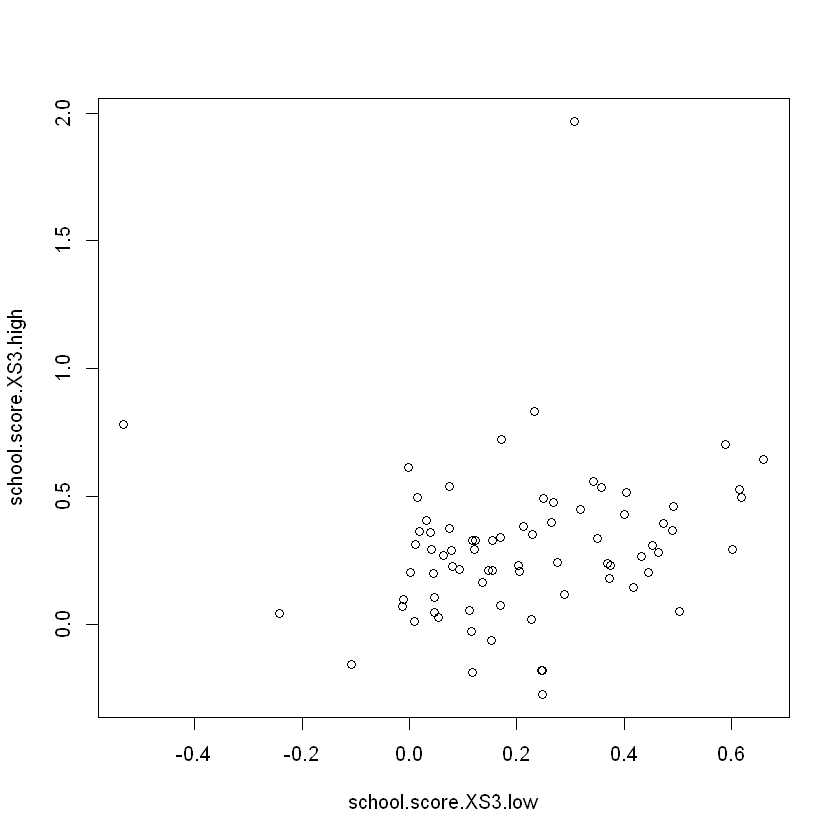

In [45]:
# formal test for S3
#

school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)


From the test performed on the variable X1 we found heterogeneity on this variable. However, the variable X2 does not seem to have heterogeneity. On the other hand, from the test performed on the variable S3 we can observe the presence of heterogeneity.

### 4. Look at school-wise heterogeneity

pdf 
  3

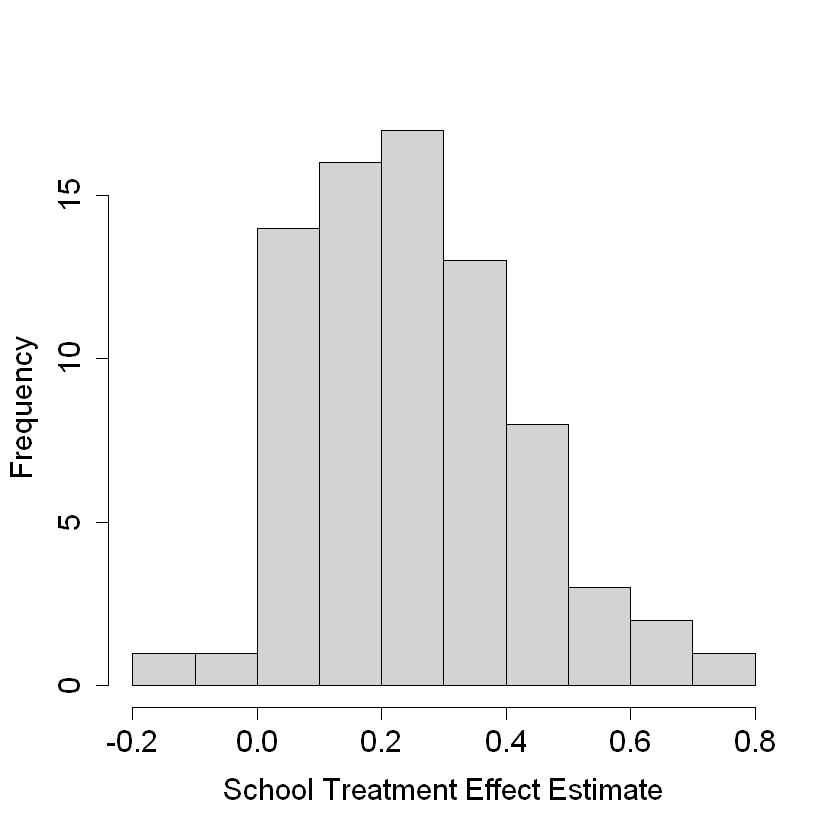

In [46]:
#PLOT
#pdf("school_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
dev.off()

The first graph helps us to observe the presence of heterogeneity. We find that it is possible to determine the presence of heterogeneity due to the large concentration of school treatment effects estimated between values 0 and 0.5.

In [47]:
# Re-check ATE... sanity check only
#

ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.248 +/- 0.04"


pdf 
  3

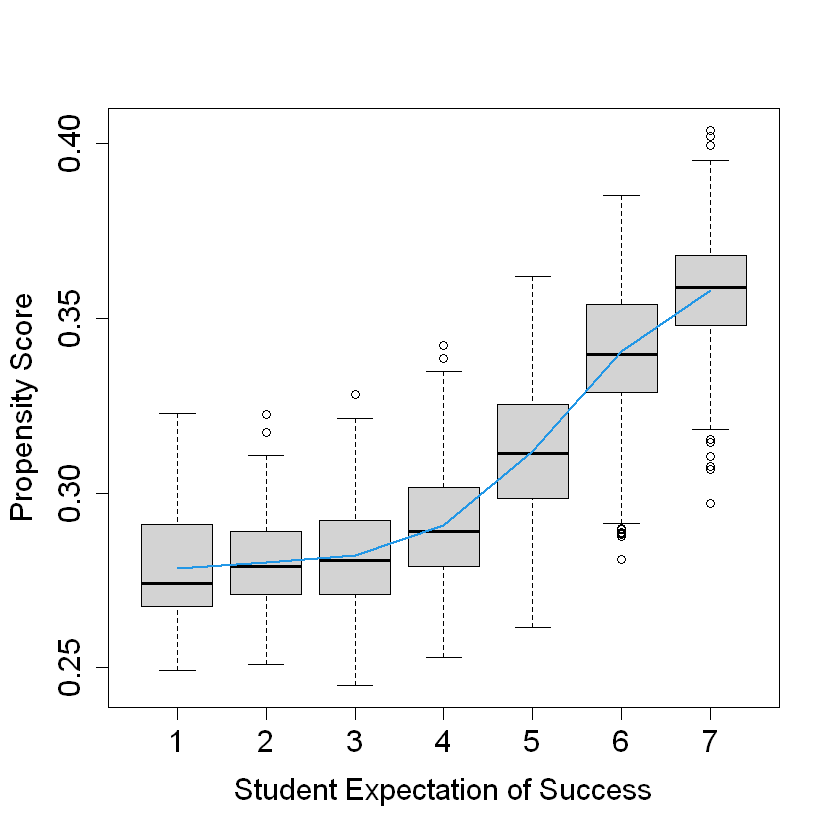

In [48]:
# Look at variation in propensity scores
#

DF = X
DF$W.hat = cf$W.hat

#PLOT
#pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
dev.off()

The second graph shows that students with higher expectation of success appears to have more probability to receive the treatment than others students (we can see it in the incresing probability score since a student expectation of success of 3).

### Analysis ignoring clusters. How do the results change?

[1] "95% CI for the ATE: 0.253 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.013601   0.045216 22.4171 < 2.2e-16 ***
differential.forest.prediction 0.528143   0.121994  4.3292 7.551e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value  Pr(>t)    
mean.forest.prediction         1.008590   0.065529 15.3914 < 2e-16 ***
differential.forest.prediction 0.381997   0.233055  1.6391 0.05061 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] -2.042824e-05  2.515531e-04

                     Df Sum Sq Mean Sq F value  Pr(>F)    
factor(school.id)    75    203   2.708   1.999 7.3e-07 ***
Residuals         10315  13972   1.355                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

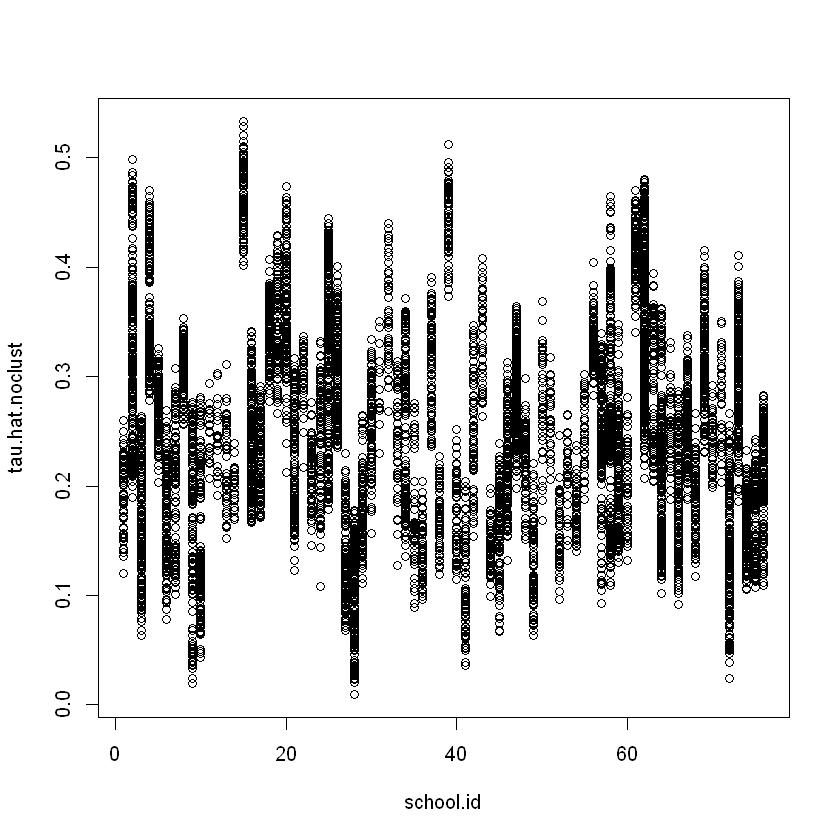

In [49]:
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

test_calibration(cf.noclust)

tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

summary(aov(dr.score ~ factor(school.id)))


Unlike the previous ATE, the ATE ignoring clusters is slightly larger and the confidence interval is smaller.

In addition, the calibration test shows the presence of heterogeneity.

### 6. Analysis without fitting the propensity score

[1] "95% CI for the ATE: 0.254 +/- 0.038"

pdf 
  3

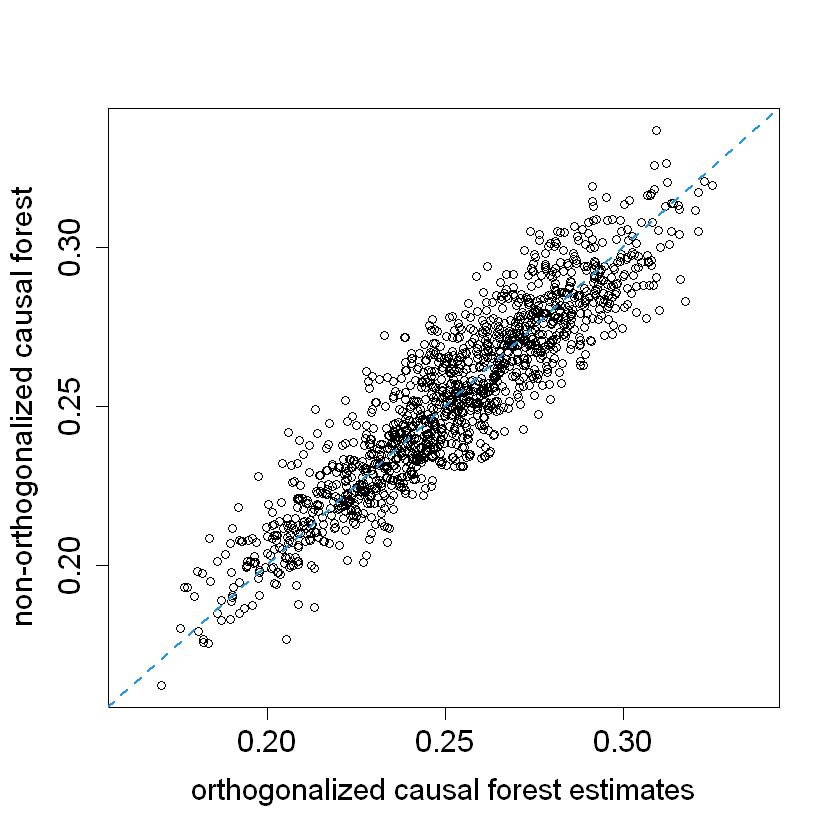

In [50]:
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

#pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()


The graph shows that the results of the CATEs of the causal forest with and without orthogonalization are very similar (they are distributed close to the 45 degree line), this implies that the orthogonalization is not very important.

In [51]:
# Train forest on school-wise DR scores
#

school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         1.000263   0.082531 12.1198 <2e-16 ***
differential.forest.prediction 0.813588   0.653713  1.2446 0.1086    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)   
(Intercept)  0.24079581  0.07773953  3.0975 0.002866 **
X1          -0.04959039  0.02966052 -1.6719 0.099273 . 
X2           0.01412785  0.03388522  0.4169 0.678081   
X3           0.00939179  0.02683438  0.3500 0.727460   
X4           0.02372228  0.02555013  0.9285 0.356552   
X5          -0.03526586  0.02708329 -1.3021 0.197399   
XC.1         0.00090015  0.09453655  0.0095 0.992432   
XC.2         0.08582749  0.10582788  0.8110 0.420275   
XC.3        -0.13553694  0.08823978 -1.5360 0.129317   
XC.4         0.04492317  0.08222504  0.5463 0.586672   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### Interpreting plots

pdf 
  3

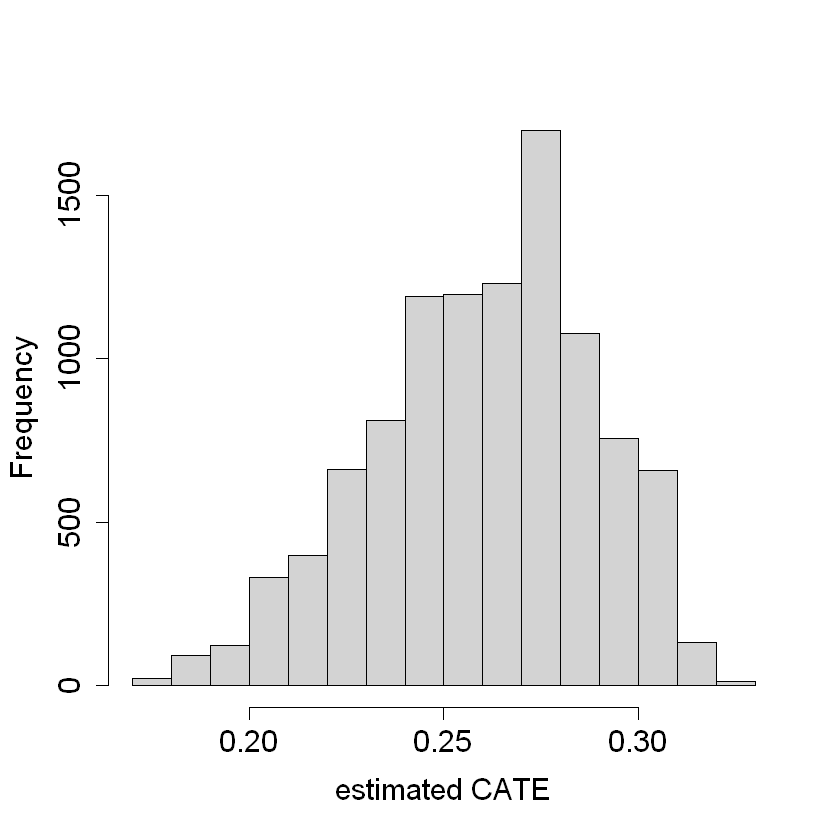

In [52]:
#pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

Some difference to a normal distribution shows presence of heterogeneity not calculated in CATE estimated.

pdf 
  3

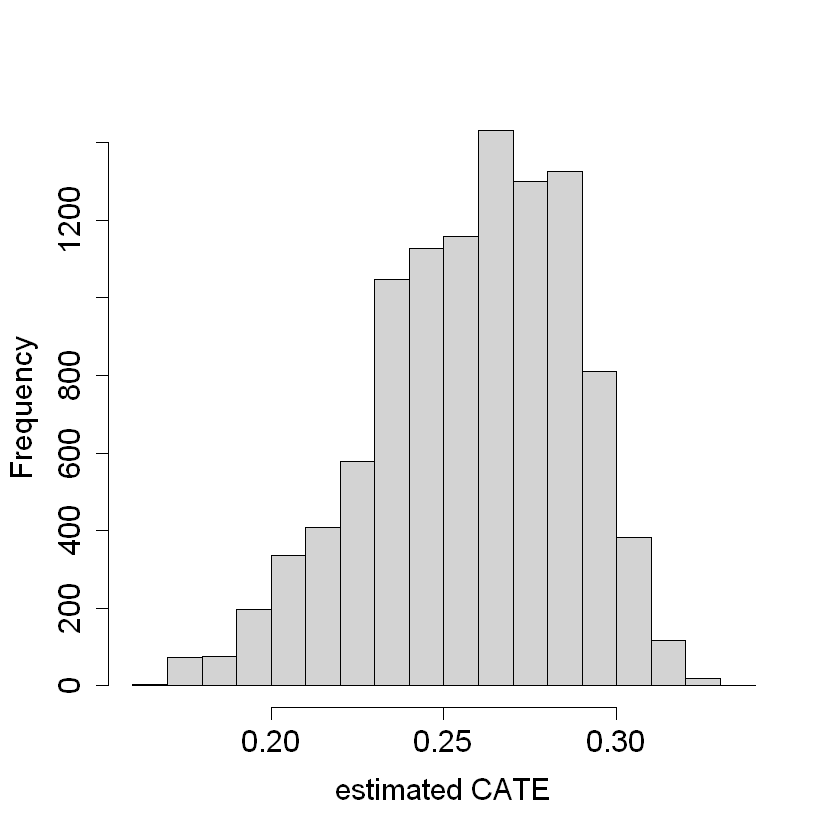

In [53]:
#pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
dev.off()

Some difference to a normal distribution shows presence of heterogeneity not calculated in CATE estimated.

pdf 
  3

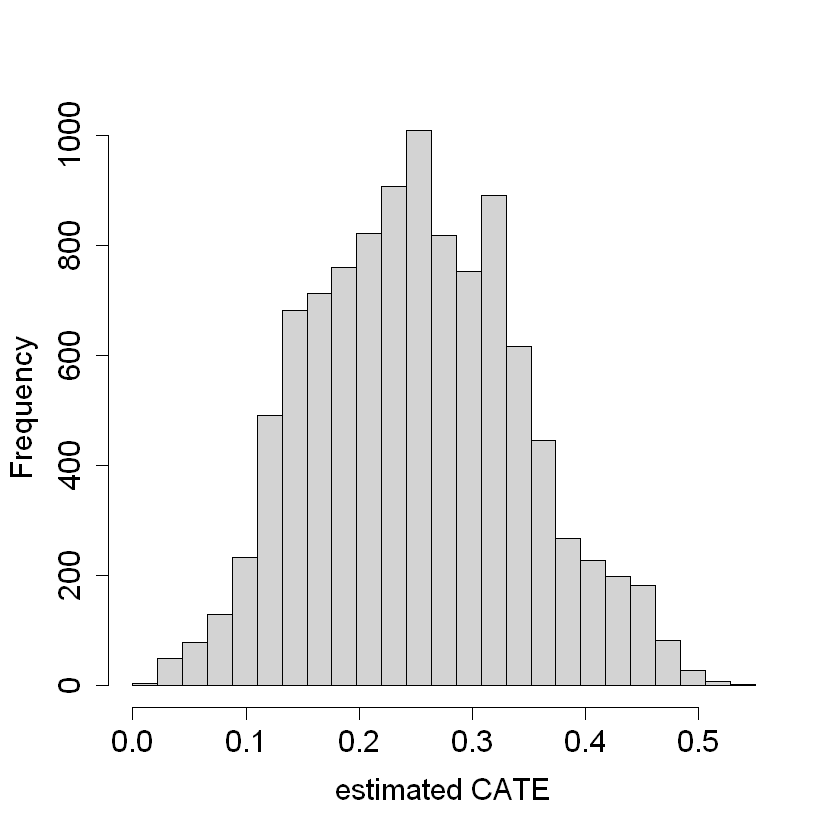

In [54]:
#pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
     breaks = seq(-0.0, 0.55, by = 0.55 / 25))
dev.off()

This graph is similar to a normal distribution but it has a large variance compared with previous graphs.

pdf 
  3

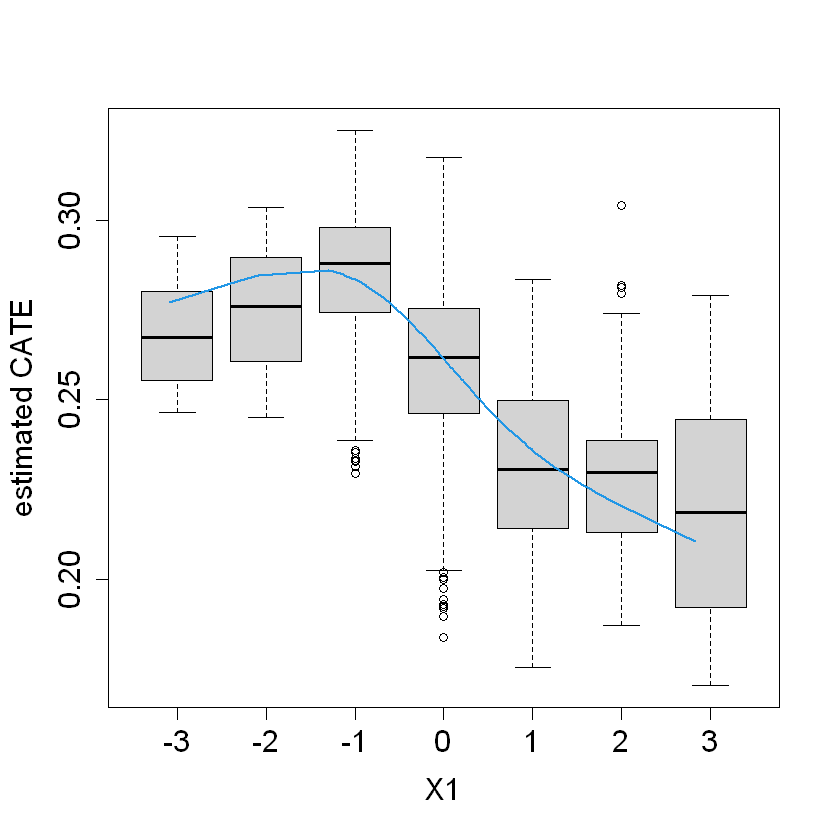

In [55]:
#pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

This graph shows the heterogeneity of x1 variable over its value.

pdf 
  3

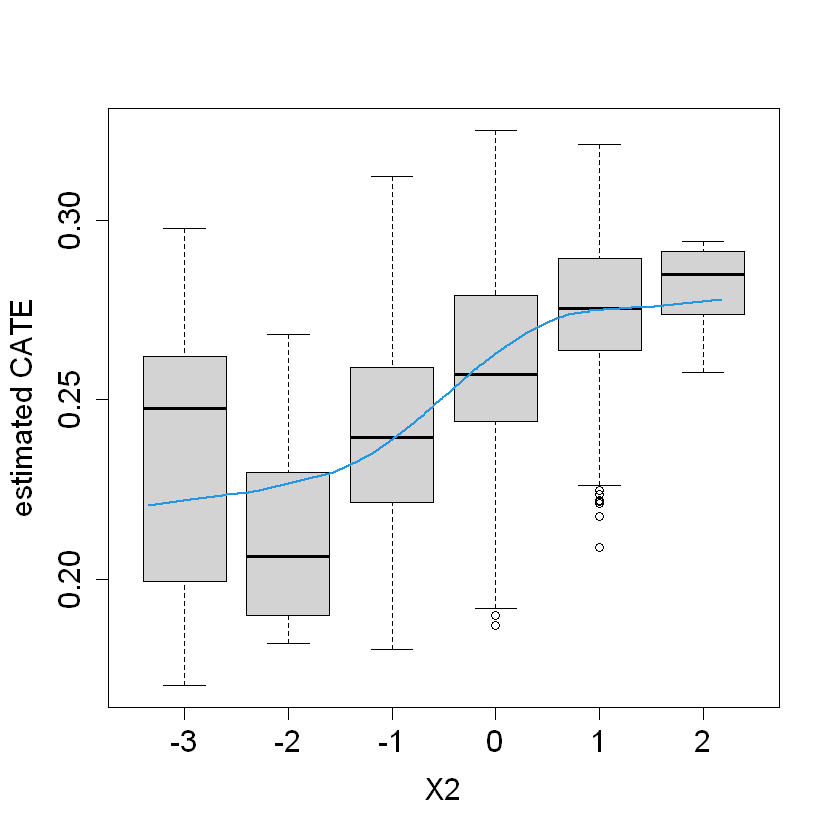

In [56]:
#pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

school.avg.tauhat = t(school.mat) %*% tau.hat / school.size

This graph shows the heterogeneity of x2 variable over its value.

pdf 
  3

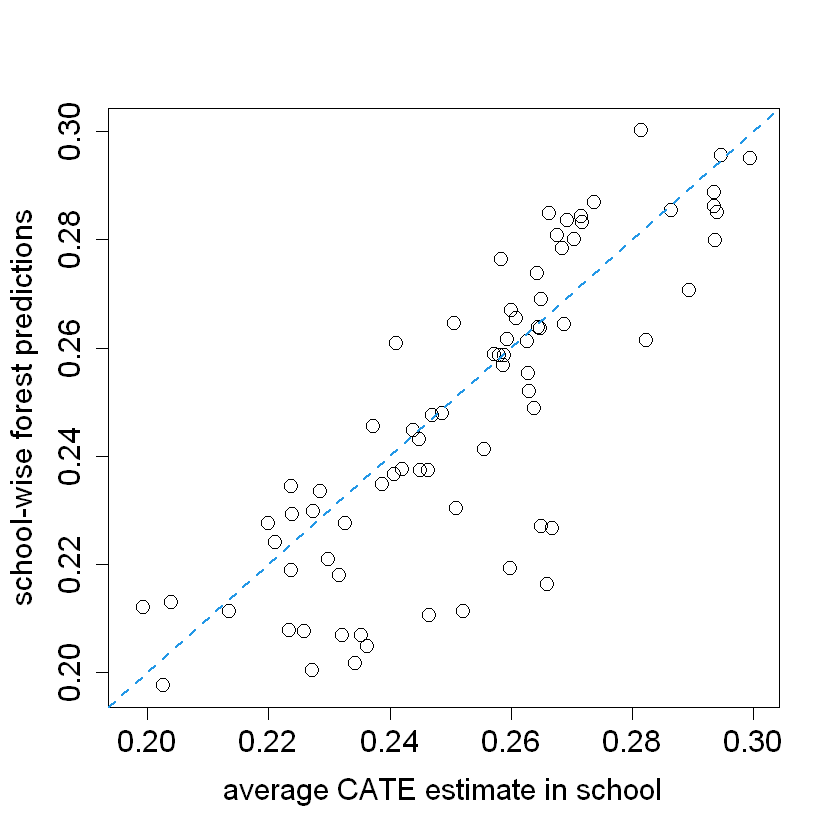

In [57]:
#pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()

This graph shows that the predictions are very similar to the estimated CATE at the school level.

### Interpretation

### 8. Visualize school-level covariates by treatment heterogeneit

[1] 0.2105263

[1] 0.5384615

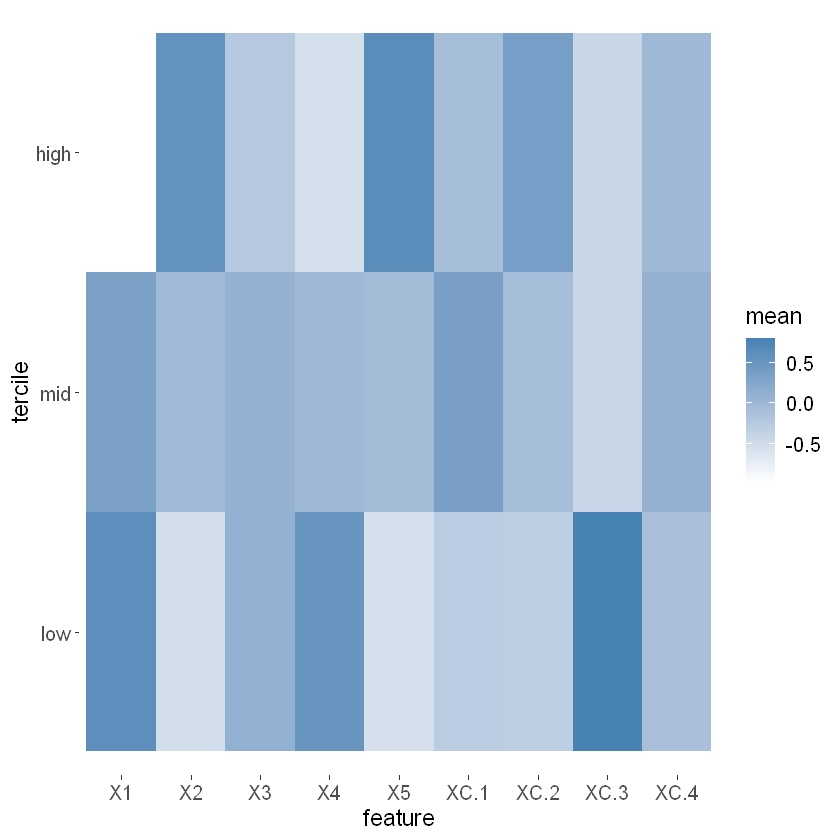

In [58]:
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

This graph shows the heterogeneity across the mean of some variables by school terciles. 

In variables X1, X4 we can see a great contrast of mean in a low tercile compared to high tercile. On the other side, we can see a great mean value of the high tercile in X2 and X5 compared to low tercile.

### 9. CATE by school

pdf 
  3

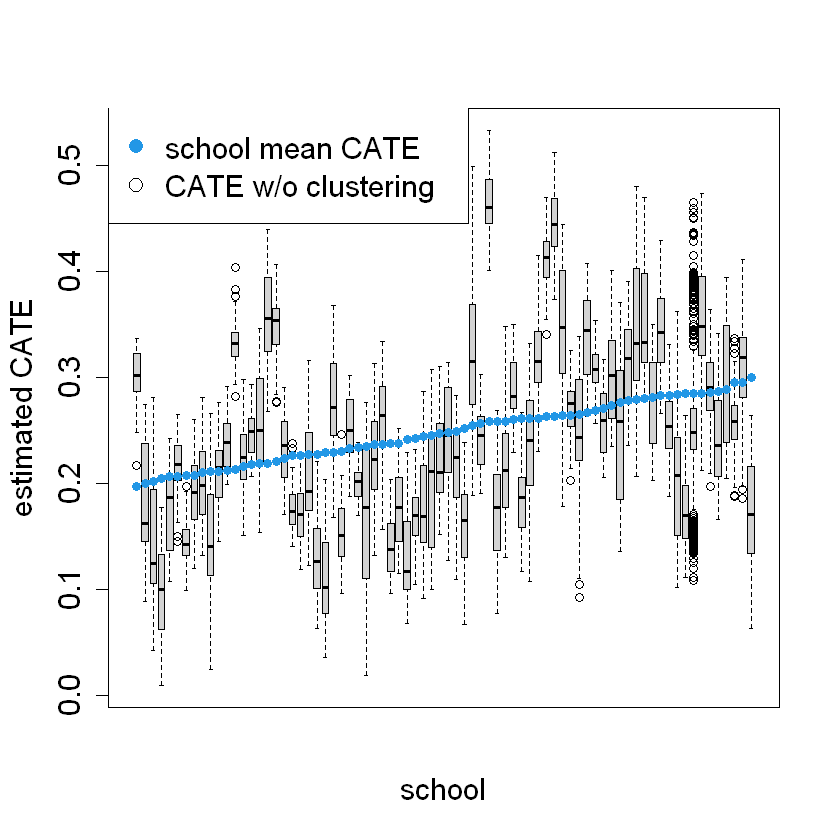

In [59]:
ord = order(order(school.pred))
school.sort = ord[school.id]

#pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
dev.off()

The analysis that does not cluster has highly variable CATE estimates at the school level, however, if the results of school mean CATE are clustered they behave differently. This implies that each school influences the results of the treatment.